<a href="https://colab.research.google.com/github/Ashithamadaraju/AnEws/blob/master/car_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [3]:
# Load the CSV file
df = pd.read_csv('/content/car data.csv')

# Display basic info
print("First 5 rows:")
display(df.head())
print("\nSummary:")
df.info()


First 5 rows:


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0



Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [4]:
# Identify columns by type
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("Missing values handled.")


Missing values handled.


In [5]:
# Add custom features if not already present
if 'Tech Adoption Score' not in df.columns:
    df['Tech Adoption Score'] = np.random.uniform(0.3, 0.9, size=len(df))
if 'Environmental Awareness' not in df.columns:
    df['Environmental Awareness'] = np.random.uniform(0.2, 0.8, size=len(df))

print("Feature engineering completed.")


Feature engineering completed.


In [12]:
# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Updated for newer sklearn
encoded_array = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols))

# Normalize numerical features
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

# Combine all processed features
df_processed = pd.concat([scaled_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

print("Encoding and normalization done.")


Encoding and normalization done.


In [13]:
# Remove outliers using IQR
Q1 = df_processed.quantile(0.25)
Q3 = df_processed.quantile(0.75)
IQR = Q3 - Q1

df_cleaned = df_processed[~((df_processed < (Q1 - 1.5 * IQR)) |
                            (df_processed > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Data shape after outlier removal: {df_cleaned.shape}")


Data shape after outlier removal: (0, 106)


In [17]:
# Remove outliers using IQR - Modified
Q1 = df_processed.quantile(0.25)
Q3 = df_processed.quantile(0.75)
IQR = Q3 - Q1

# Adjust the IQR multiplier (e.g., from 1.5 to a smaller value)
# or use a different outlier handling method if necessary
# For example, using Z-score:
from scipy import stats
z_scores = np.abs(stats.zscore(df_processed))
df_cleaned = df_processed[(z_scores < 3).all(axis=1)] # Keep data within 3 std devs

# Alternatively, cap outliers instead of removing them:
# upper_limit = Q3 + 1.5 * IQR
# lower_limit = Q1 - 1.5 * IQR
# df_cleaned = df_processed.clip(lower=lower_limit, upper=upper_limit, axis=1)


print(f"Data shape after outlier removal: {df_cleaned.shape}")

Data shape after outlier removal: (0, 106)


In [21]:
# Remove outliers using IQR - Modified
Q1 = df_processed.quantile(0.25)
Q3 = df_processed.quantile(0.75)
IQR = Q3 - Q1

# Adjust the IQR multiplier (e.g., from 1.5 to a smaller value)
# or use a different outlier handling method if necessary
# For example, using Z-score:
#from scipy import stats
#z_scores = np.abs(stats.zscore(df_processed))
#df_cleaned = df_processed[(z_scores < 3).all(axis=1)] # Keep data within 3 std devs

# Alternatively, cap outliers instead of removing them:
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR
df_cleaned = df_processed.clip(lower=lower_limit, upper=upper_limit, axis=1) #Cap instead of remove


print(f"Data shape after outlier removal: {df_cleaned.shape}")

Data shape after outlier removal: (301, 106)


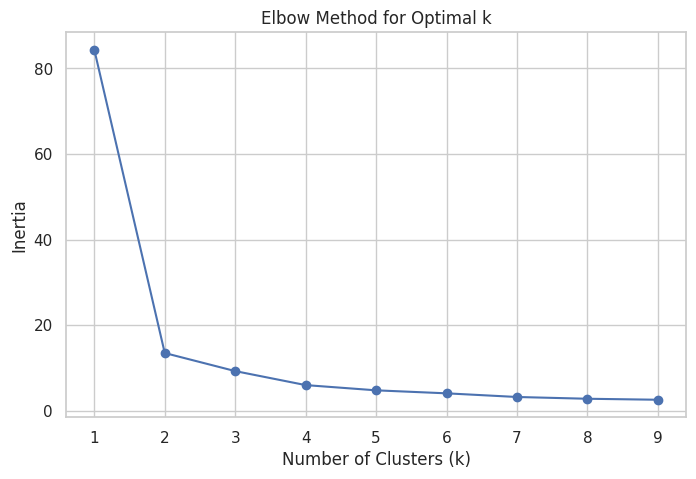

In [20]:
# Elbow method to find optimal number of clusters
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cleaned)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(K)
plt.grid(True)
plt.show()


In [22]:
# Apply KMeans with chosen number of clusters (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(df_cleaned)

print("KMeans clustering applied. Cluster labels added.")
print(df_cleaned['Cluster'].value_counts())


KMeans clustering applied. Cluster labels added.
Cluster
1    145
0    106
2     50
Name: count, dtype: int64


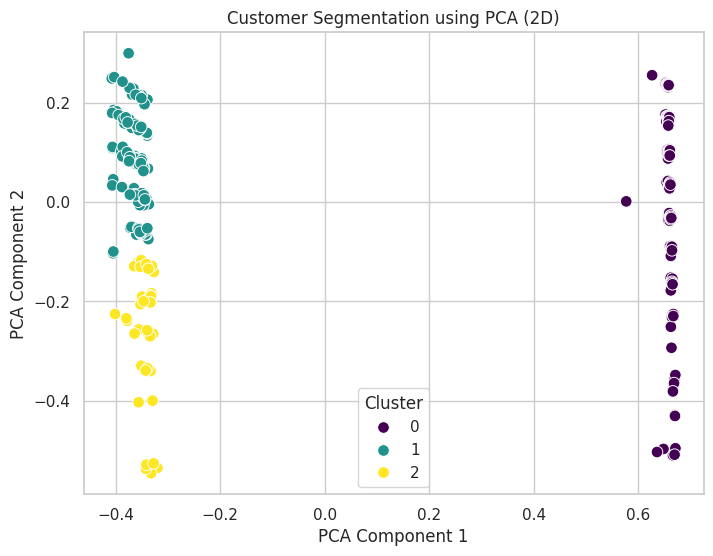

In [23]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_cleaned.drop('Cluster', axis=1))

df_cleaned['PCA1'] = pca_result[:, 0]
df_cleaned['PCA2'] = pca_result[:, 1]

# Visualize clusters in 2D
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=70)
plt.title("Customer Segmentation using PCA (2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()
